#  Insurance Fraud Predictive Model 

First, let's import all of the necessary modules we will be using. 

In [1]:
# Installed packages 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 
import pandas as pd 
from ipywidgets import widgets
import regex as re
import plotly.express as px
import datetime

#supresses warnings 
import warnings
warnings.filterwarnings('ignore')

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown

# Pandas profiling for fast EDA 
from pandas_profiling import ProfileReport

# Goal and Overview 
**Problem Statement:**
The data contains different insurance claims, including fraudulent and non-fraudulent claims. 
Build a predictive model to detect whether a claim is fraudulent (1) or not (0). 

**Challenges:** 
Selecting useful features.
Making use of qualitative data. 
Dealing with missing data. 

**Steps:** 
1. Data Cleaning 
2. Exploratory Data Analysis 
3. Feature Engineering 
4. Predictive Modeling 
5. Model Evaluation


Note: 
You can install *pandas_profiling* using the pip package manager by running
`!pip install pandas-profiling[notebook]` in this notebook

# Data Pre-processing

In [2]:
# read csv and view 
claims = pd.read_csv("Claims.csv")
claims.head(5)

claimnumber                     name updatetime         lossdate  fault  \
0     42-3069       Collision Rear-end    14:50.4  11/17/2017 1:12    0.0   
1     42-3082  Collision while Backing    18:32.5  11/16/2018 4:17  100.0   
2     42-3083  Collision while Parked     49:28.0  8/30/2017 12:29    0.0   
3     42-3085                   Animal    19:42.9   8/26/2018 0:16    0.0   
4     42-3088    Collision Hit and Run    27:53.3   12/1/2017 0:02    0.0   

   fraud insured_sex  insured_occupation auto_make  months_as_customer  \
0    0.0        male                 6.0     SMART                44.0   
1    1.0        male                 1.0    SUBARU                 1.0   
2    0.0      female                 4.0     SMART                66.0   
3    0.0      female                 5.0     OTHER                38.0   
4    0.0      female                 6.0    SUBARU                 8.0   

  insured_state incident_severity property_damage  bodily_injuries  
0            PA      Major Damage             YES              1.0  
1            CA      Minor Damage               ?              0.0  
2            CA      Minor Damage              NO              2.0  
3            CA      Major Damage               ?              1.0  
4            PA      Minor Damage              NO              0.0

In [3]:
# all the columns in Claims 
claims.dtypes

claimnumber            object
name                   object
updatetime             object
lossdate               object
fault                 float64
fraud                 float64
insured_sex            object
insured_occupation    float64
auto_make              object
months_as_customer    float64
insured_state          object
incident_severity      object
property_damage        object
bodily_injuries       float64
dtype: object

Now, I will be using pandas profiling to gain quick insight into the data, such as how many missing data there are in each column. More information on pandas profiling can be found [Here](https://github.com/pandas-profiling/pandas-profiling).

In [4]:
# Generate the Profiling Report 
profile = ProfileReport(claims, title = "Claims Dataset", html={'style': {'full_width':True}})

In [5]:
profile

## Insight From Pandas Profiling 
#### Duplicates 
We have a total of *43157* observations, *30935* of which are duplicate rows.
* In other words, 73.6% of our data are duplicates
* Action: Remove Duplicates
    
#### Missing Data 
In the last rows, we can see that there are * a lot * of rows where all columns are none. 
* Claim Number Missing is 30936, one more than the 30935 duplicate rows. The duplicate rows are probably coming from the all null rows. 
* For each column, the number of missing data is roughly around 30935. 


## Data Cleaning

In [6]:
# Remove all duplicates and drop the all null rows. 
claims = claims.drop_duplicates()
claims = claims.dropna(how='all') # Only drop rows where everything is Null 
claims

claimnumber                      name updatetime          lossdate  \
0         42-3069        Collision Rear-end    14:50.4   11/17/2017 1:12   
1         42-3082   Collision while Backing    18:32.5   11/16/2018 4:17   
2         42-3083   Collision while Parked     49:28.0   8/30/2017 12:29   
3         42-3085                    Animal    19:42.9    8/26/2018 0:16   
4         42-3088     Collision Hit and Run    27:53.3    12/1/2017 0:02   
...           ...                       ...        ...               ...   
12216     44-0041  Collision while Turning     40:28.4  11/16/2018 22:31   
12217     44-0042                      Fire    28:46.9   3/18/2018 16:09   
12218     44-0043  Collision while Turning     46:28.9  12/28/2017 10:48   
12219     44-0044  Collision while Turning     16:12.2   6/22/2017 14:47   
12220     44-0045               Glass Only     29:09.5    3/6/2017 10:00   

       fault  fraud    insured_sex  insured_occupation auto_make  \
0        0.0    0.0           male                 6.0     SMART   
1      100.0    1.0           male                 1.0    SUBARU   
2        0.0    0.0         female                 4.0     SMART   
3        0.0    0.0         female                 5.0     OTHER   
4        0.0    0.0         female                 6.0    SUBARU   
...      ...    ...            ...                 ...       ...   
12216    0.0    1.0         female                 1.0    SUBARU   
12217    0.0    0.0  nonConforming                 7.0     SMART   
12218  100.0    0.0         female                 1.0    SUBARU   
12219    0.0    0.0         female                 6.0    SUBARU   
12220    0.0    1.0           male                 4.0    SUZUKI   

       months_as_customer insured_state incident_severity property_damage  \
0                    44.0            PA      Major Damage             YES   
1                     1.0            CA      Minor Damage               ?   
2                    66.0            CA      Minor Damage              NO   
3                    38.0            CA      Major Damage               ?   
4                     8.0            PA      Minor Damage              NO   
...                   ...           ...               ...             ...   
12216                20.0            AZ      Minor Damage             YES   
12217                24.0            AZ        Total Loss             YES   
12218                44.0            CA      Minor Damage             YES   
12219                40.0            CA      Minor Damage             YES   
12220                 4.0            CA      Minor Damage             YES   

       bodily_injuries  
0                  1.0  
1                  0.0  
2                  2.0  
3                  1.0  
4                  0.0  
...                ...  
12216              NaN  
12217              NaN  
12218              NaN  
12219              NaN  
12220              NaN  

[12221 rows x 14 columns]

In [7]:
# generate the profile report again now that we've dropped duplicates and removed null. 
profile = ProfileReport(claims, title = "Claims Dataset", html={'style': {'full_width':True}})
profile

Much Better! For each columns, the proportions of missing values dropped to around 0%. 


Uh Oh! We can see that bodily_injuries still have 91.8% missing value. Later in this notebook, I will look at whether or not bodily injuries would be a useful feature or not. If not, we will drop the column. 

## More Data Cleaning

From exploring the data further, I see that there are inconsistency in the spelling. For example, there is "Collision at Intersectionion" and "Collision at Intersect" which are both the same thing. So, I'm going to change them both to "Collision at Intersection". Also "SUBUWU" and "SUBARU" 

In [8]:
claims['auto_make'].unique() # SUBARU and SUBUWU 

array(['SMART', 'SUBARU', 'OTHER', 'MERCEDES-BENZ', 'SUZUKI', 'TOYOTA',
       'NISSAN', 'VOLKSWAGEN', 'VOLVO', 'SUBUWU', nan, 'TESLA'],
      dtype=object)

In [9]:
claims['name'].unique() # Collision at Insersect and Collision at Intersection

array(['Collision Rear-end', 'Collision while Backing',
       'Collision while Parked ', 'Animal', 'Collision Hit and Run',
       'Collision Rearend', 'Collision with Fixed Object', 'Vandalism',
       'Collision Other', 'Collision at Intersection',
       'Comprehensive Other ', 'Glass Only ', 'Collision while Turning ',
       'Theft of Entire Vehicle', 'Collision at Intersect',
       'Impact with Falling/Flying Object', 'Collision while Parking ',
       'Collision Rollaway/Unattended', 'Theft Audio',
       'Collision Solo Accident',
       'All Risk - Mechanical (paint, brakes, all other)',
       'Collision while Changing Lanes', 'Collision with Bicycle',
       'Collision with Pedestrian', 'Collision with Motorcycle ',
       'Collision with Motor Vehicle', 'Fire',
       'Collision with Train or Bus', 'Explosion',
       'Pedestrian/Insured Injury Only ', 'Water', 'Windstorm', 'Hail'],
      dtype=object)

In [10]:
def cleanClaims(data): 
    """Cleans up the data by fixing spelling mistakes and same categories spelt differently"""
    data['name'] = data['name'].str.replace('-','')
    data['name'] = data['name'].str.replace('Collision at Intersection', "Collision at Intersect").str.lower()
    data['auto_make'] = data['auto_make'].str.replace("SUBUWU", "SUBARU") # UWU 
    return data 

In [11]:
claims = cleanClaims(claims)

In [12]:
claims['name'].unique() #Gone!

array(['collision rearend', 'collision while backing',
       'collision while parked ', 'animal', 'collision hit and run',
       'collision with fixed object', 'vandalism', 'collision other',
       'collision at intersect', 'comprehensive other ', 'glass only ',
       'collision while turning ', 'theft of entire vehicle',
       'impact with falling/flying object', 'collision while parking ',
       'collision rollaway/unattended', 'theft audio',
       'collision solo accident',
       'all risk  mechanical (paint, brakes, all other)',
       'collision while changing lanes', 'collision with bicycle',
       'collision with pedestrian', 'collision with motorcycle ',
       'collision with motor vehicle', 'fire',
       'collision with train or bus', 'explosion',
       'pedestrian/insured injury only ', 'water', 'windstorm', 'hail'],
      dtype=object)

# EDA 

## Most Frequent Claims 

The top 3 claims are **collision rearend, glass only, and collision while turning.** 

In [13]:
topThreeClaims = np.array(claims['name'].value_counts()[0:3].index)
topThreeClaims

array(['collision rearend', 'glass only ', 'collision while turning '],
      dtype=object)

Now, let's convert the string dates into datetime object so it's easier to work with! 

In [14]:
def convertToDateTimeObject(series): 
    pattern = '%m/%d/%Y %H:%M'
    return series.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))

In [15]:
top3Claims = claims[claims['name'].isin(topThreeClaims)]
top3Claims['lossdatetime'] = convertToDateTimeObject(top3Claims['lossdate'])
top3Claims['Loss Date'] = top3Claims['lossdatetime'].apply(lambda x : x.strftime("%b") + "-" + str(x.year))
top3ClaimsByDate = top3Claims[['name','Loss Date', "lossdatetime"]].groupby(["name", 'Loss Date']).agg('count').reset_index()
top3ClaimsByDate = top3ClaimsByDate.rename(columns={"lossdatetime":"count"})

In [16]:
top3ClaimsDF = {}
for claim in topThreeClaims: 
    top3ClaimsDF[claim] = top3ClaimsByDate[top3ClaimsByDate['name'] == claim]

In [17]:
order = ['Jan-2017', 'Feb-2017', 'Mar-2017', 'Apr-2017', 
          'May-2017', 'Jun-2017', 'Jul-2017','Aug-2017', 
          'Sep-2017',  'Oct-2017',  'Nov-2017', 'Dec-2017',
          'Jan-2018', 'Feb-2018', 'Mar-2018',  'Apr-2018',
          'May-2018', 'Jun-2018', 'Jul-2018', 'Aug-2018', 
          'Sep-2018', 'Oct-2018', 'Nov-2018','Dec-2018',
            ]

for claim in top3ClaimsDF: 
    top3ClaimsDF[claim] = top3ClaimsDF[claim].set_index('Loss Date').loc[order].reset_index()

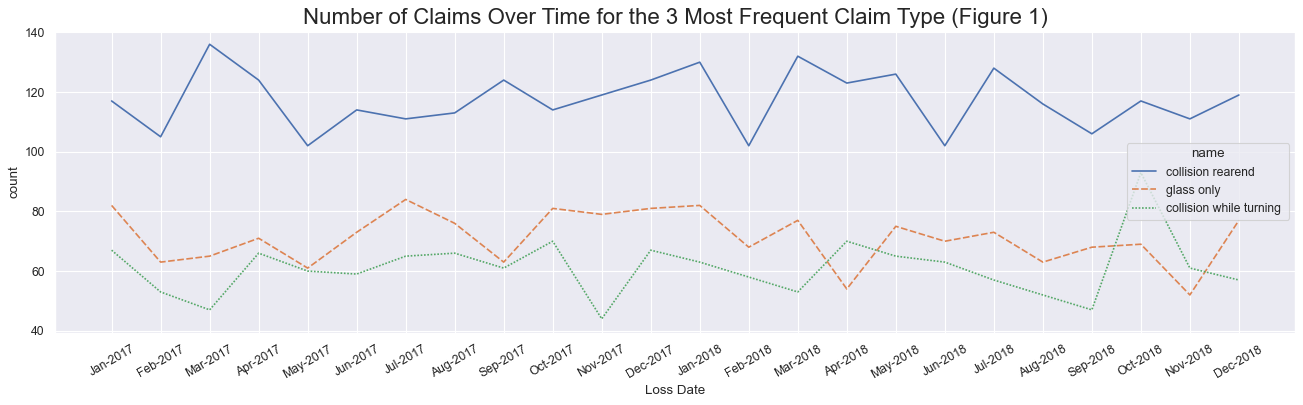

In [18]:
figure(figsize=(20, 5), dpi=80)
sortedTop3 = pd.concat(top3ClaimsDF.values())
ax = sns.lineplot(data=sortedTop3, x="Loss Date", y="count", hue="name", style="name")
plt.setp(ax.get_xticklabels(), rotation=30)
plt.title("Number of Claims Over Time for the 3 Most Frequent Claim Type (Figure 1)", fontsize=20)
plt.show()

# General Trends 

Text(0.5, 1.0, 'Number of Claims over Hours in Day (Figure 2)')

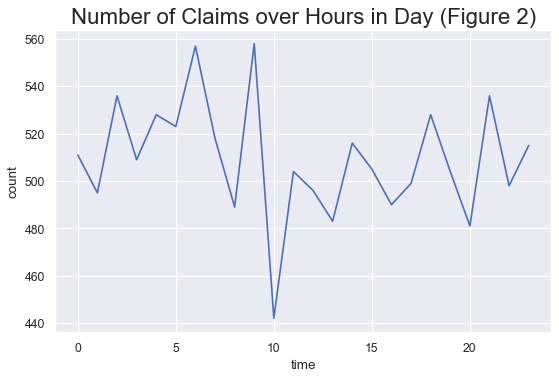

In [19]:
figure(figsize=(8, 5), dpi=80)
# for call 
claims2 = claims.copy()
claims2['lossdatetime'] = convertToDateTimeObject(claims2['lossdate'])
claims2['time'] = claims2['lossdatetime'].apply(lambda x: x.hour)

# for fraud only 
claims3 = claims2.copy()
claims3 = claims3[claims3['fraud'] == 1][['time', 'fraud']]

claims2 = claims2[['time','fraud']]
claims2 = claims2.groupby("time").agg('count').reset_index().rename(columns={'fraud':'count'})
ax = sns.lineplot(data=claims2, x="time", y="count")
plt.title("Number of Claims over Hours in Day (Figure 2)", fontsize=20)

Text(0.5, 1.0, 'Number of Fraud Claims over Hour in Day (Figure 3)')

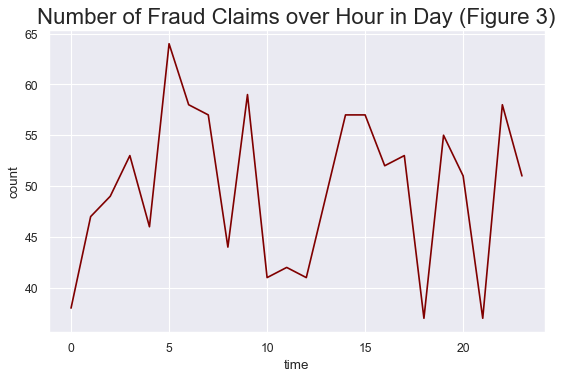

In [20]:
claims3 = claims3.groupby("time").agg('count').reset_index().rename(columns={'fraud':'count'})
figure(figsize=(8, 5), dpi=80)
ax = sns.lineplot(data=claims3, x = "time", y="count", color = 'maroon')
plt.title("Number of Fraud Claims over Hour in Day (Figure 3)", fontsize=20)

Text(0.5, 1.0, 'Number of Fraud Claims over Months (Figure 4)')

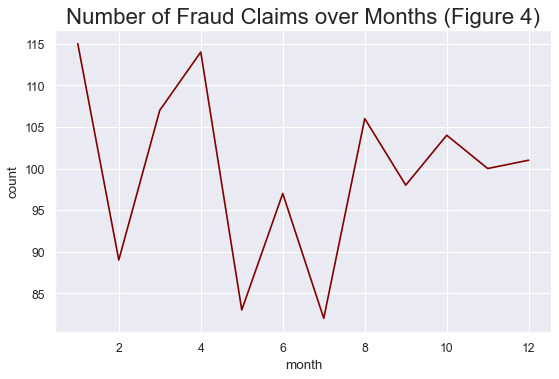

In [21]:
figure(figsize=(8, 5), dpi=80)
# for fraud only 
claims4 = claims.copy()
claims4['lossdatetime'] = convertToDateTimeObject(claims4['lossdate'])
claims4['month'] = claims4['lossdatetime'].apply(lambda x: x.month)
claims4 = claims4[claims4['fraud'] == 1]
claims4 = claims4[['fraud', 'month']].groupby("month").agg('count').reset_index().rename(columns={'fraud':'count'})
ax = sns.lineplot(data=claims4, x = "month", y="count", color = 'maroon')
plt.title("Number of Fraud Claims over Months (Figure 4)", fontsize=20)

### Interpretation
From this figure, we can see that some months has significantly higher fraudulent claims than other. Noticeable peaks are around January, April, October and December. 

In [22]:
claimsMonth = claims[['months_as_customer', 'fraud']]
claimsMonth = claimsMonth.dropna(subset=['months_as_customer']) # There was one single null value 

In [23]:
# # Plotly for interactivity 
# fig = px.box(claimsMonth, x='fraud', 
#              y="months_as_customer", 
#              title = "Distribution of Months as Customer for Fraud and Non-Fraud Claims (Figure 5)")
# fig.update_layout(yaxis_title="Months as Customer")
# fig.show()

Text(0.5, 1.0, 'Distribution of Months as Customer for Fraud and Non-Fraud Claims (Figure 5)')

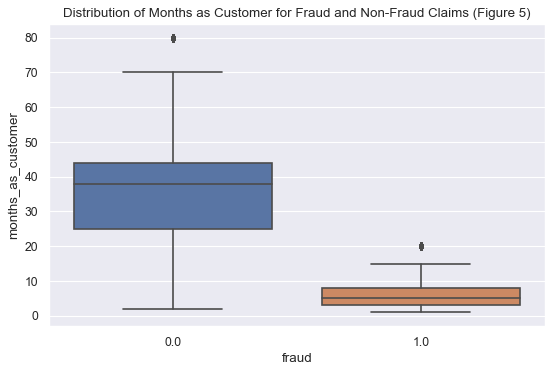

In [24]:
figure(figsize=(8, 5), dpi=80)
sns.boxplot(data=claimsMonth, y='months_as_customer', x = 'fraud').set_title("Distribution of Months as Customer for Fraud and Non-Fraud Claims (Figure 5)")

Text(0.5, 1.0, 'Month as Customer vs Fraud')

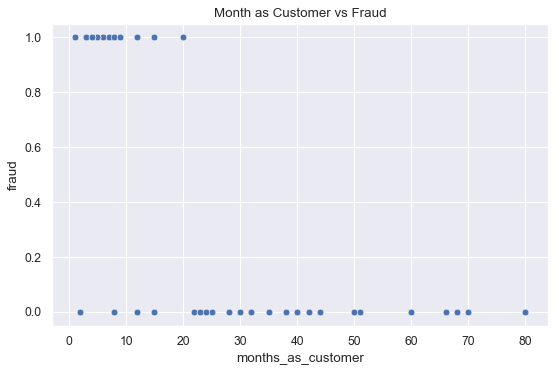

In [25]:
# Would be a great feature to use in our random forest model. 
figure(figsize=(8, 5), dpi=80)
sns.scatterplot(data=claimsMonth, x='months_as_customer', y='fraud').set_title("Month as Customer vs Fraud")

### Interpretation
From the boxplot above, we can see a distinction in in Months as Customer vs whether or not a claim is fraudulent. The Months as customer for all customers who filed fraudulent claims are lower than the 25th percentile of non-fraudulent claims. 

The median months as customer of non-fraudulent claims is 38 months whereas the median for that of fraudulent claims is 5 months. **Months as Customer** would be a great feature to use in a predictiev model. 

## Collisions 

In [26]:
# Filter for collisions only 
re_collision = r'collision'
collisionClaims = claims[claims['name'].apply(lambda x: len(re.findall(re_collision, x)) > 0 )]

In [27]:
collisionClaims['name'].unique()

array(['collision rearend', 'collision while backing',
       'collision while parked ', 'collision hit and run',
       'collision with fixed object', 'collision other',
       'collision at intersect', 'collision while turning ',
       'collision while parking ', 'collision rollaway/unattended',
       'collision solo accident', 'collision while changing lanes',
       'collision with bicycle', 'collision with pedestrian',
       'collision with motorcycle ', 'collision with motor vehicle',
       'collision with train or bus'], dtype=object)

In [28]:
print("There are {} Collissions".format(collisionClaims.shape[0]))
print("{} of which were frauds.".format(collisionClaims['fraud'].value_counts()[1.0]))

There are 8876 Collissions
863 of which were frauds.


Now, let's look closer at each type of Collisions and how many of them were fradulent v.s not fraudulent. 

Text(0.5, 1.0, 'Distribution of Type of Collisions (Figure 6)')

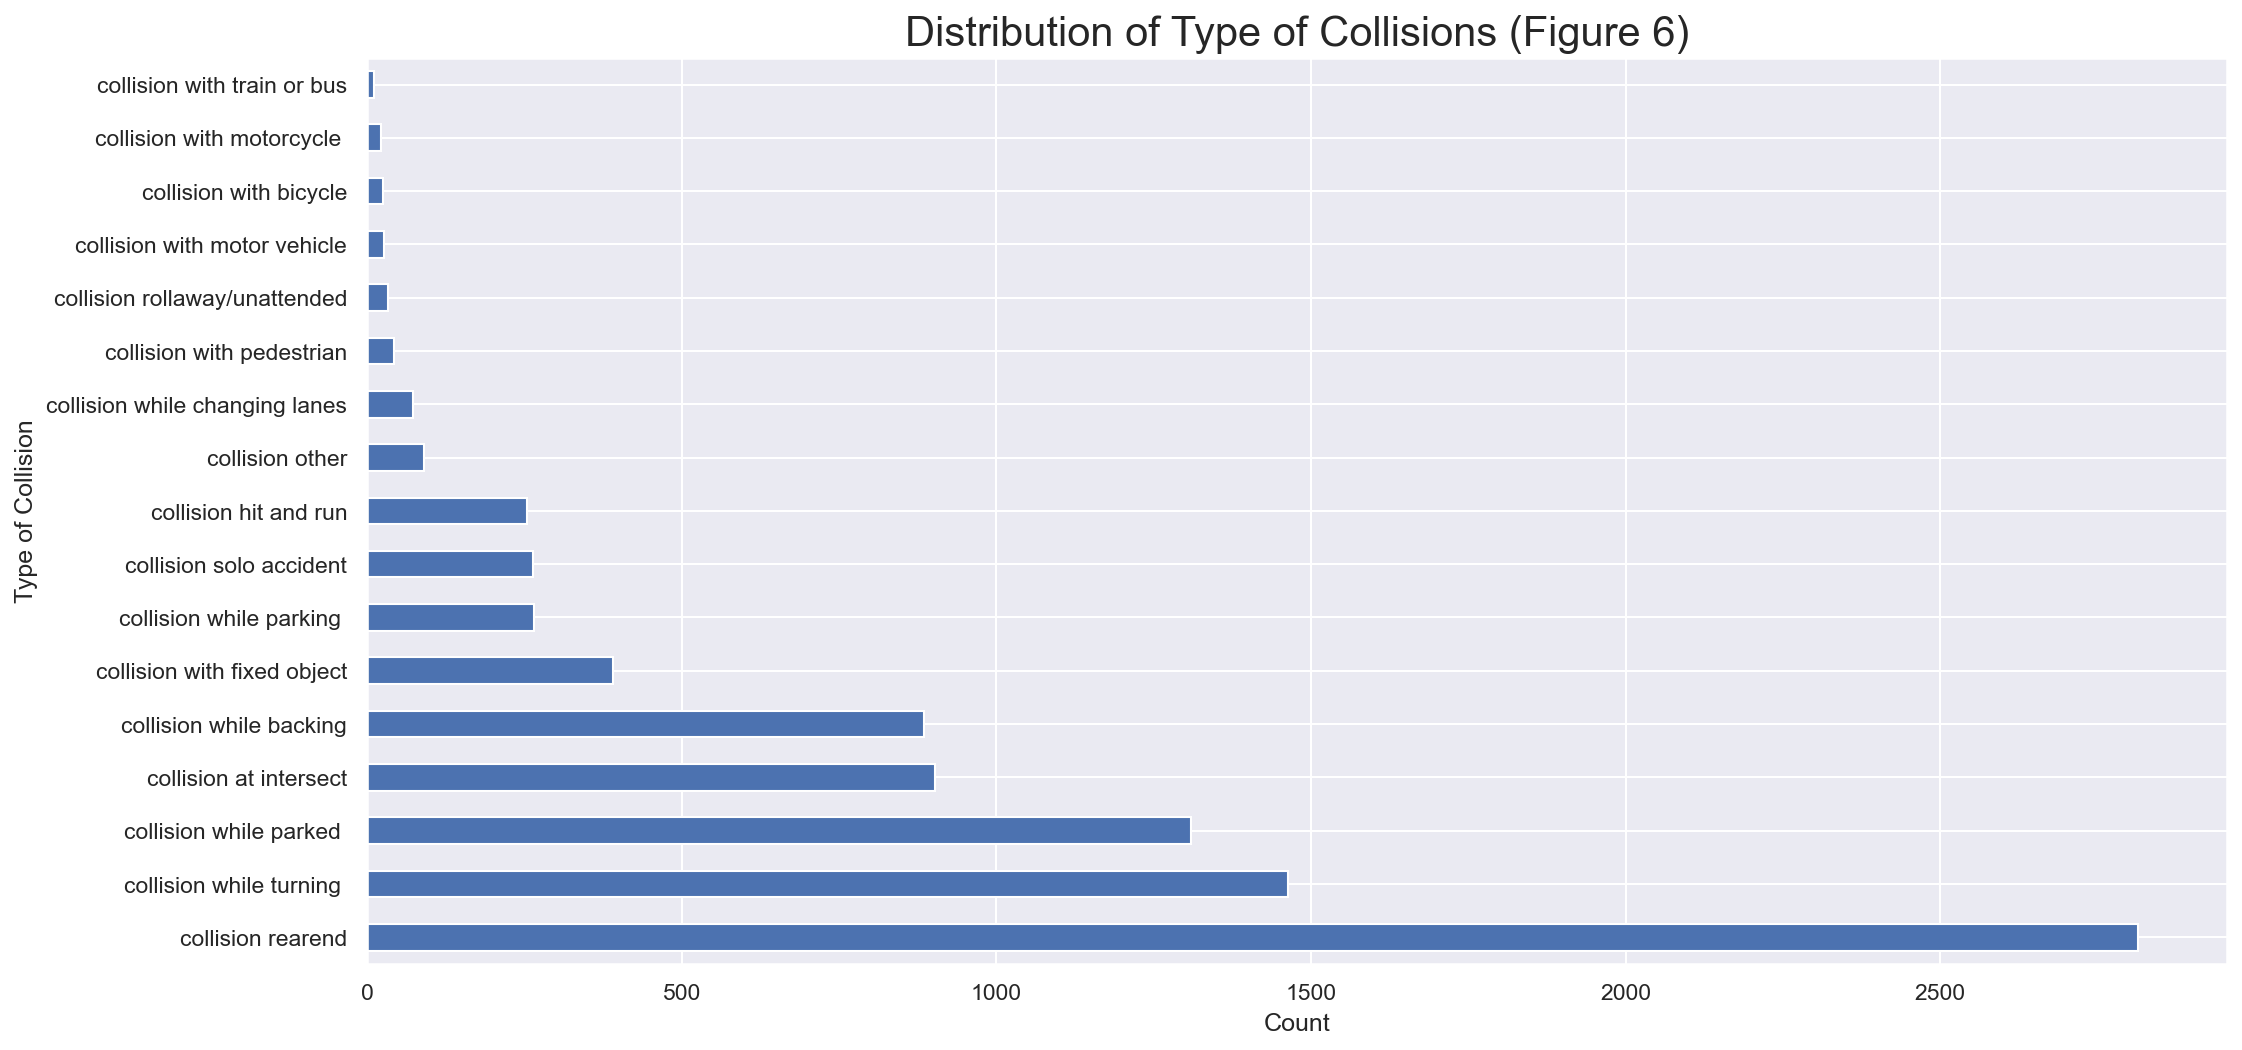

In [29]:
collisionClaimsCount = collisionClaims['name'].value_counts()
collisionClaimsCount.plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Type of Collision")
plt.title("Distribution of Type of Collisions (Figure 6)", fontsize=20)

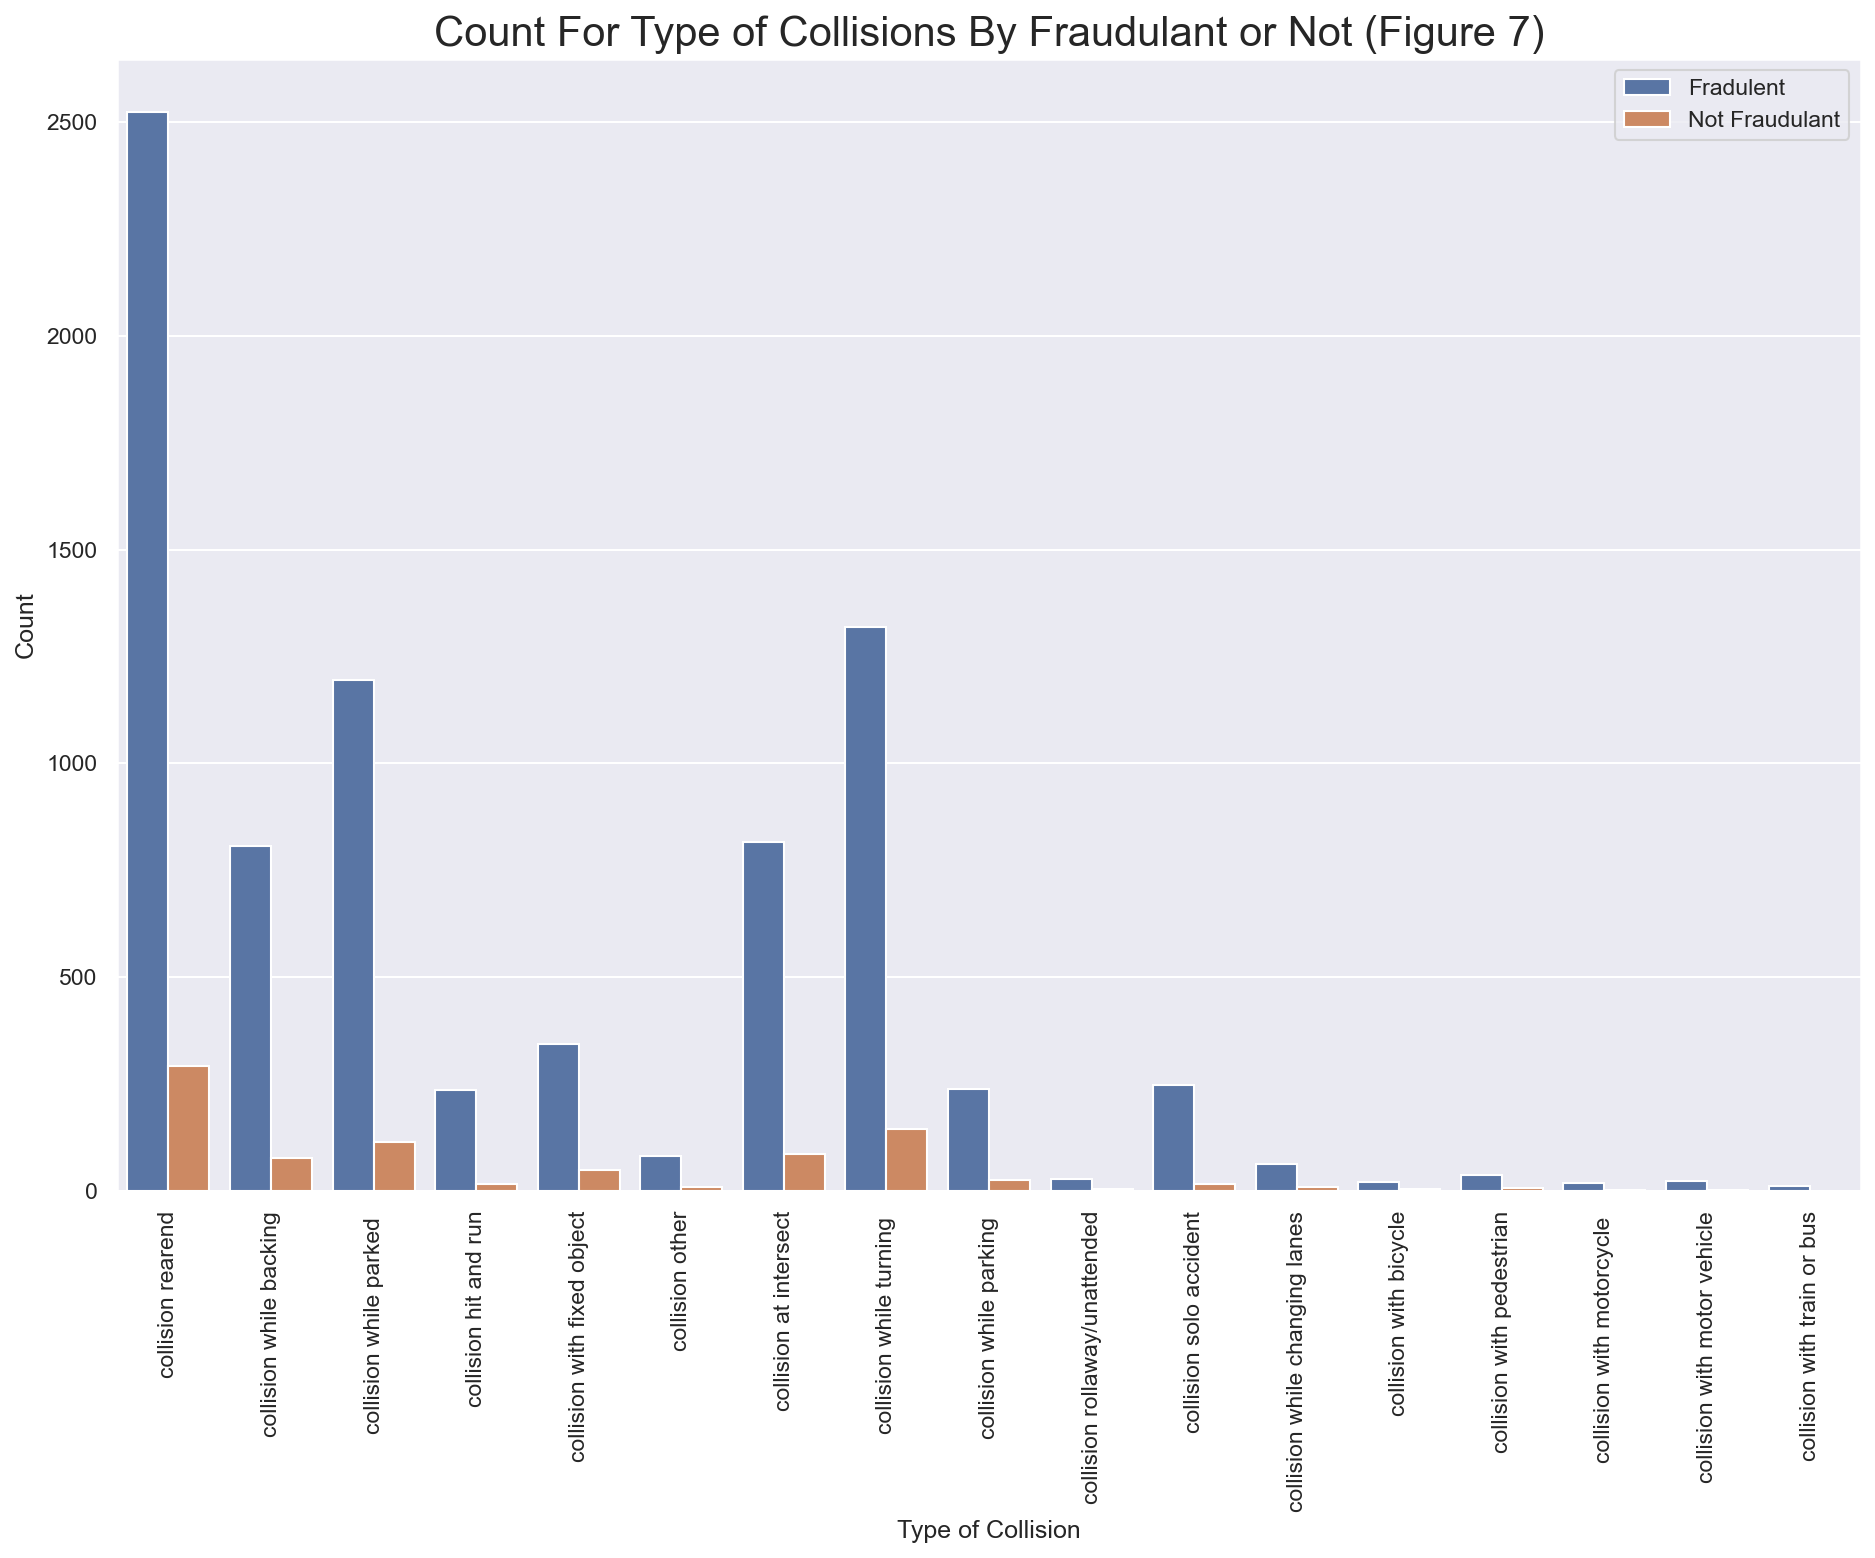

In [30]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x = 'name', hue="fraud", data=collisionClaims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Count For Type of Collisions By Fraudulant or Not (Figure 7)", fontsize = 20)
plt.xlabel("Type of Collision")
plt.ylabel("Count")
plt.legend(loc='upper right', labels=['Fradulent', 'Not Fraudulant'])
plt.show(ax)

It might be more helpful to look at the proportion of fradualent claims for each type of collisions. 

In [31]:
collisionFraudProp = collisionClaims[['name', 'fraud']].groupby('name').agg(lambda x: round(np.mean(x), 2)).reset_index().rename(columns = {"fraud":"fraud proportion"})

Text(0, 0.5, 'Type of Collision')

<Figure size 750x750 with 0 Axes>

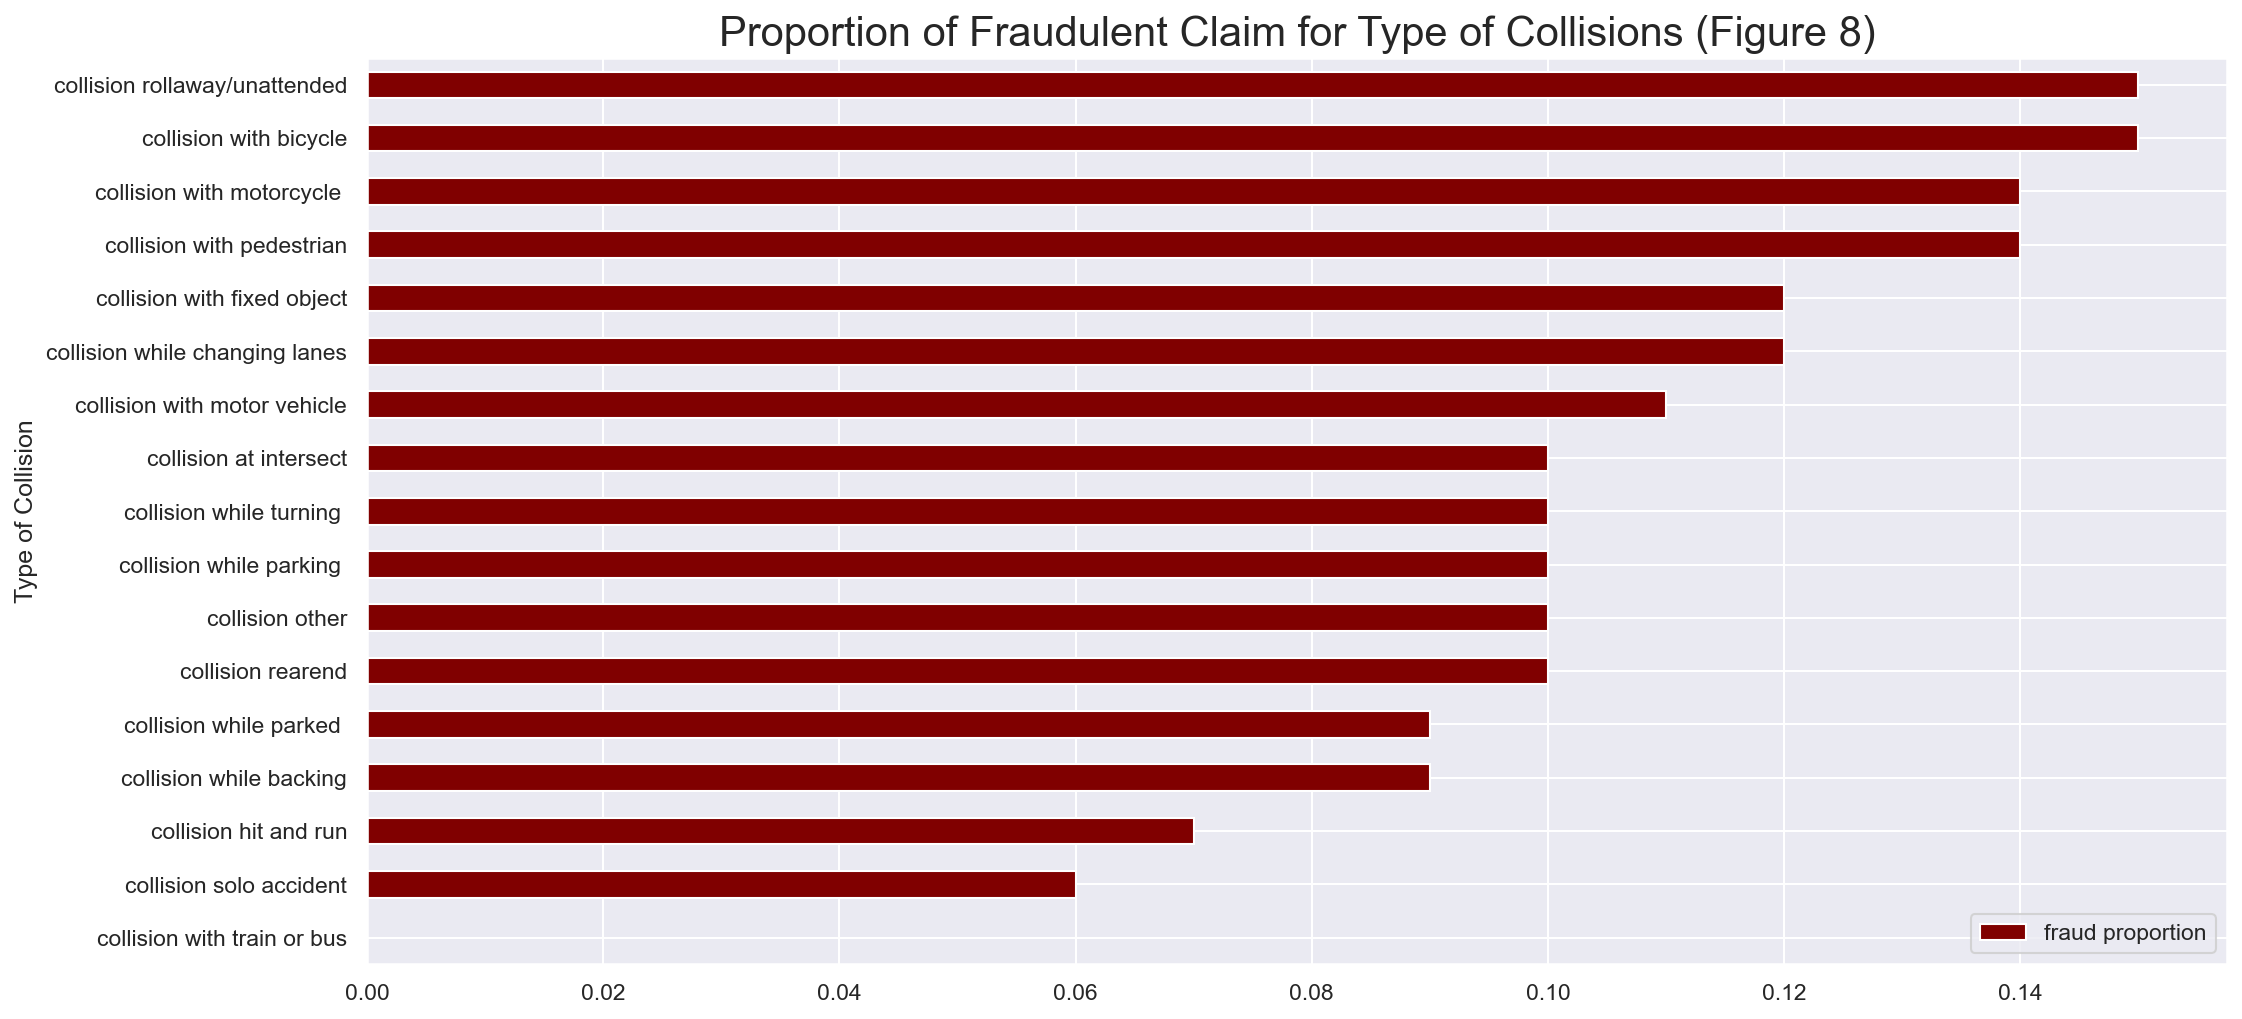

In [32]:
plt.figure(figsize=(5,5))
collisionFraudProp.sort_values('fraud proportion', inplace=True)
collisionFraudProp.plot.barh(x='name', color='maroon')
plt.legend(loc='lower right')
plt.title("Proportion of Fraudulent Claim for Type of Collisions (Figure 8)", fontsize = 20)
plt.ylabel("Type of Collision")

### Interpretation
* `Collision Rollaway/Unattended` and `Collision with Bicycle` did not make up a large proportion of collision claims (`Figure 1`) but has the highest proportion of fradulent claims (`Figure 3`) at 15% for both.


* `Collision with Motorcycle` and `Collision with Pedestrian` also did not make up a large proportion of collision claims but has the second highest proportion of fradulent claims at 14% for both. 

It appears that less frequent type of collisions in our dataset are showing a higher proportion of fradulent activities. 

* The most frequent types of Collisions (i.e `Collision Rearend`, `Collision at Intersection`, `Collision while Parking`) have around 10% of fraudulent claim. 

* 0% of collision with train or bus claims were found to be fraudulent. This is likely because collisions with a train or bus is often severe, so I hypothesize that someone looking to do insurance fraud would less likely to get in some kind of collision with train or bus simply for insurance fraud.


### Collision: Fraud Proportion By Car Type 

Text(0, 0.5, 'Auto Make')

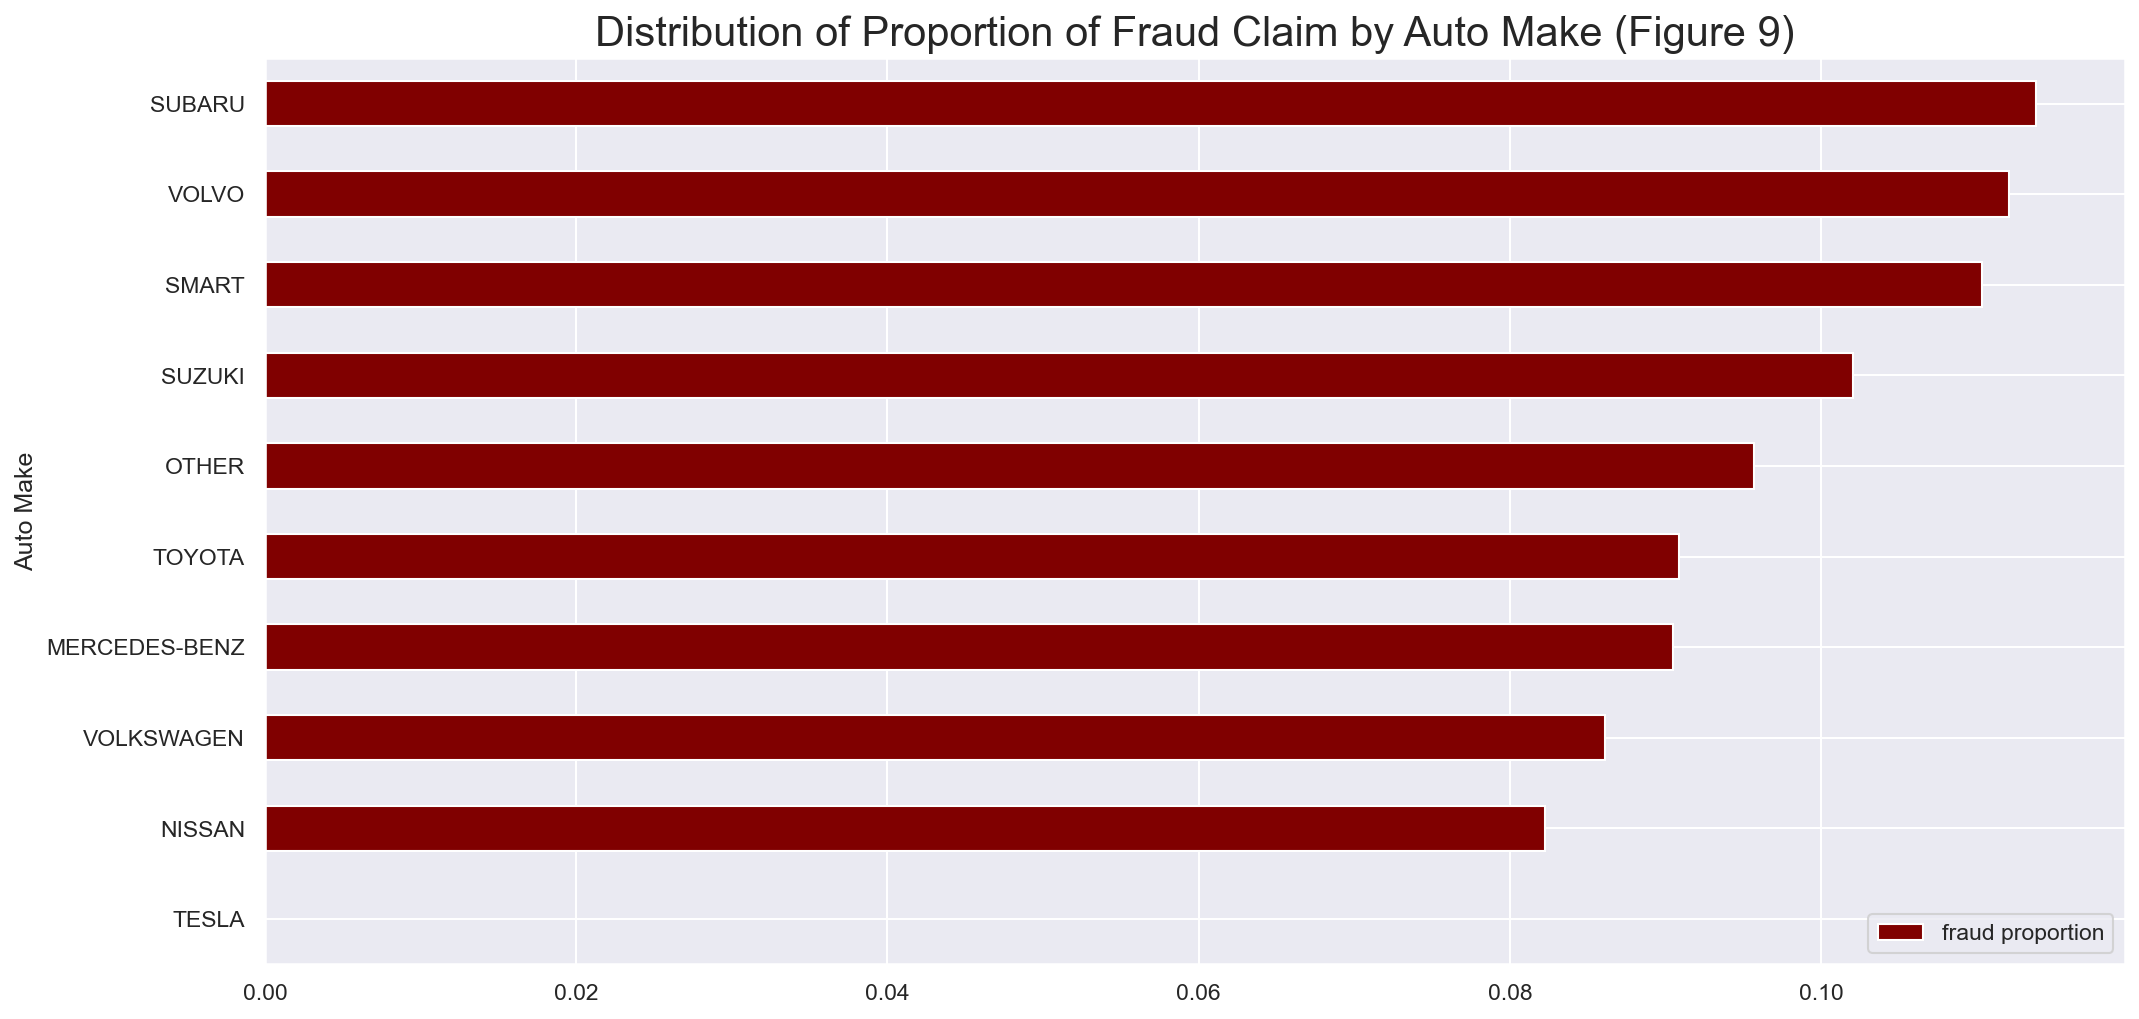

In [33]:
collisionByCar = collisionClaims[['auto_make', 'fraud']].groupby('auto_make').agg('mean').rename(columns = {"fraud":"fraud proportion"})
collisionByCar.sort_values('fraud proportion', inplace=True)
collisionByCar.plot.barh(color='maroon')
plt.legend(loc='lower right')
plt.title("Distribution of Proportion of Fraud Claim by Auto Make (Figure 9)", fontsize = 20)
plt.ylabel("Auto Make")

## Incident Severity and Fraud Claims

In [34]:
claims[['incident_severity', 'fraud']].fillna("Other").groupby('incident_severity').agg('mean')

fraud
incident_severity          
Major Damage       0.093486
Minor Damage       0.098720
Total Loss         0.100728
Trivial Damage     0.098720

There appears to be around the same proportion of fraud among all type of incident severity, all around 9-10%. However, Total Loss has the highest proportion of fradulent claim. 

## Bodily Injuries and Fraud 

Text(0, 0.5, 'Bodily Injuries')

<Figure size 1500x750 with 0 Axes>

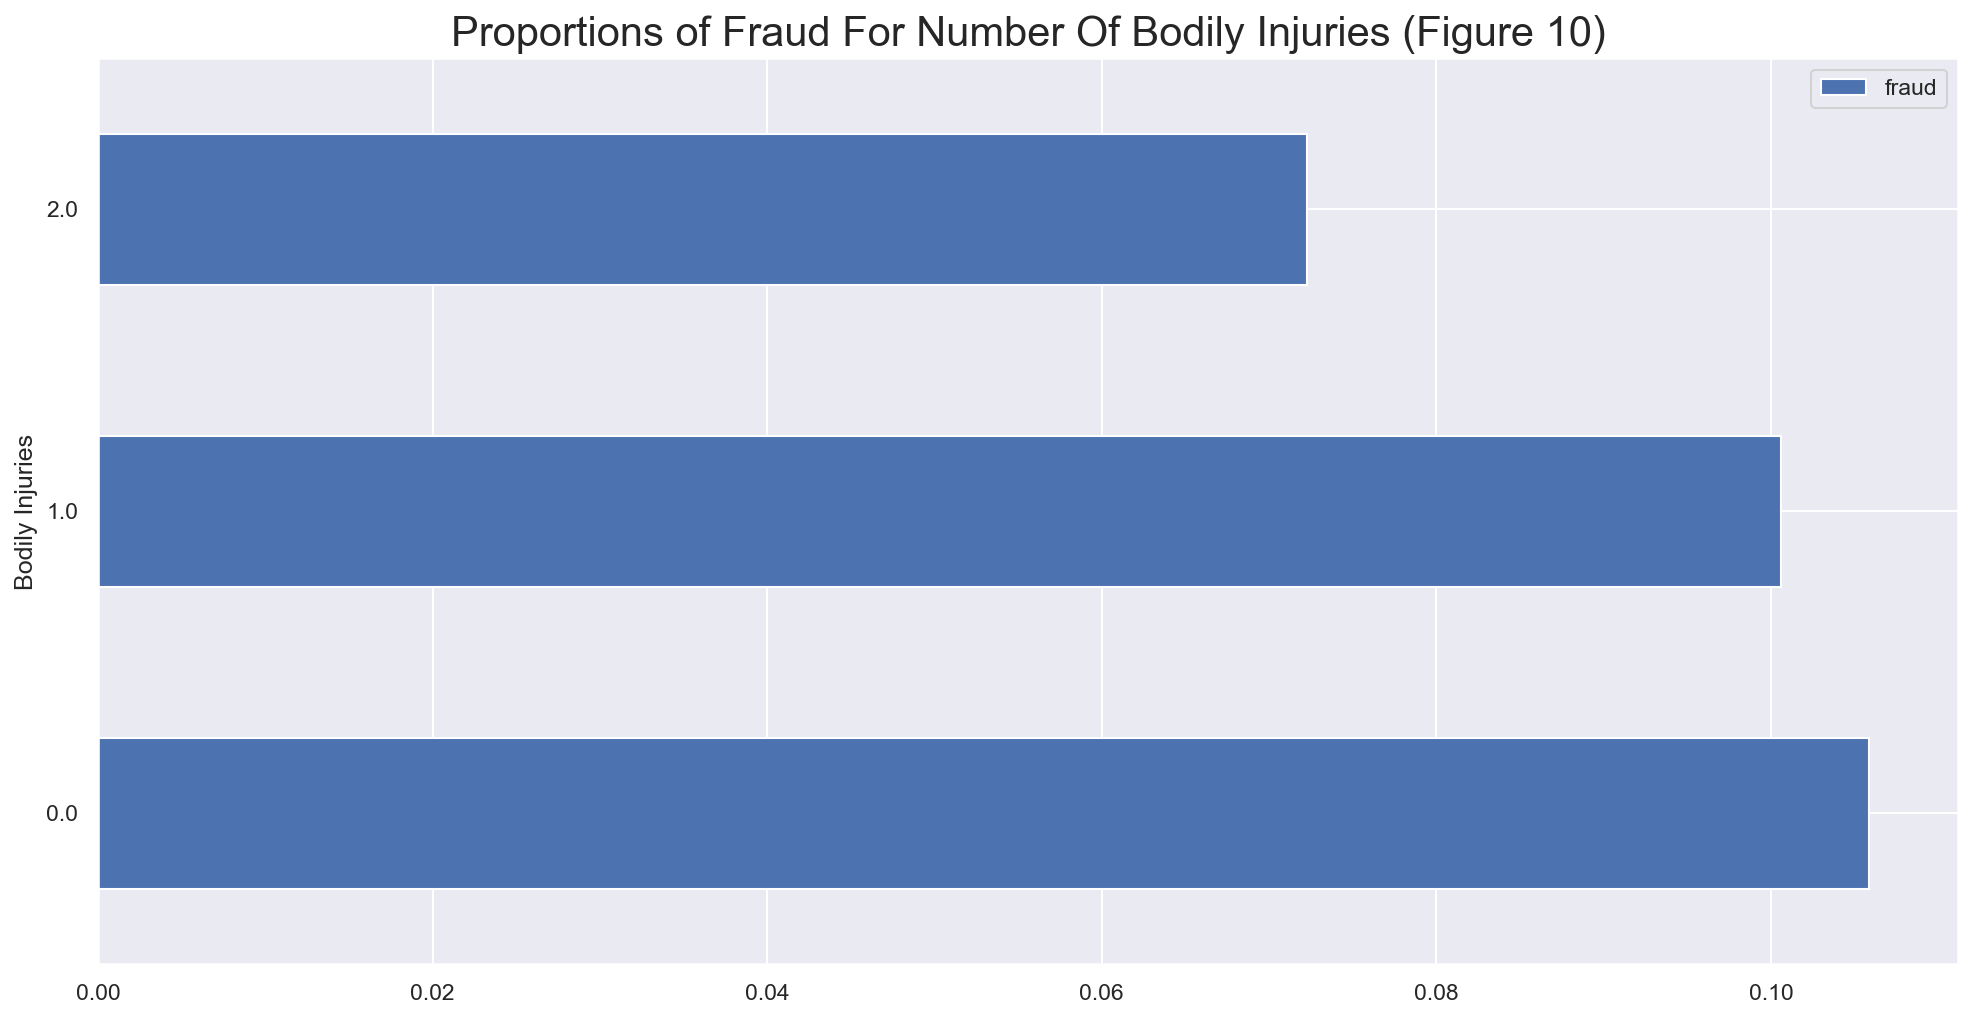

In [35]:
plt.figure(figsize=(10,5))
claims[['bodily_injuries', 'fraud']].dropna().groupby('bodily_injuries').agg('mean').plot(kind='barh')
plt.title("Proportions of Fraud For Number Of Bodily Injuries (Figure 10)", fontsize=20)
plt.ylabel("Bodily Injuries")

## Claims with Highest Fraud Proportion

Text(0, 0.5, 'Claim Type')

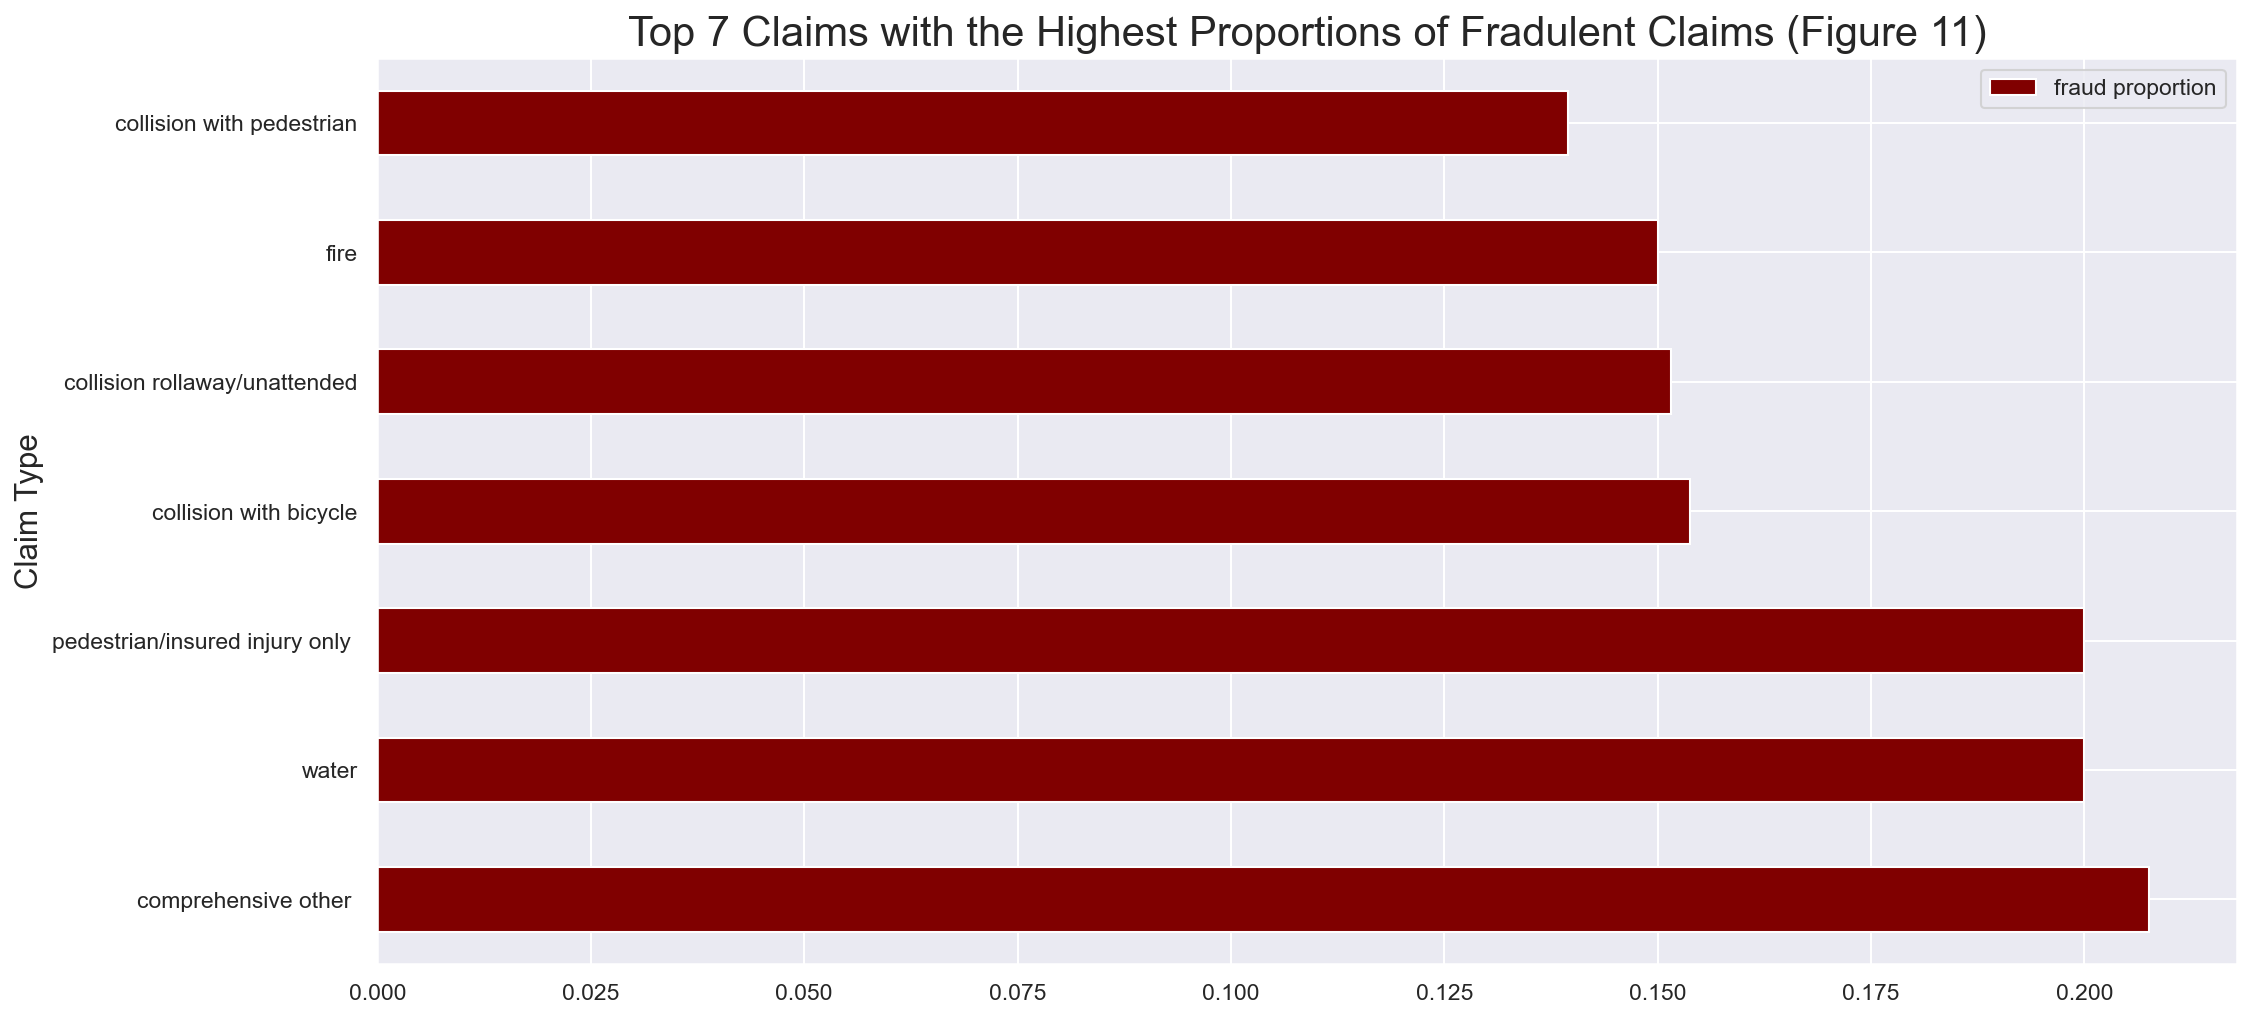

In [36]:
top7claimfraud = claims.groupby('name').agg('mean')[['fraud']].rename(columns={'fraud':'fraud proportion'}).sort_values('fraud proportion', ascending = False).head(7)
top7claimfraud.plot.barh(color='maroon')
plt.title("Top 7 Claims with the Highest Proportions of Fradulent Claims (Figure 11)", fontsize=20)
plt.ylabel("Claim Type", fontsize=15)

Here, we can see that the claim types with the highest proportion of fraud falls under "comprehensive other", "water", "pedestrian/insured injury online", "collision with bicycle", "fire", etc.

## Gender and Fraud Proportion 

Text(0.5, 1.0, 'Sex and Proportion of Fraud (Figure 12)')

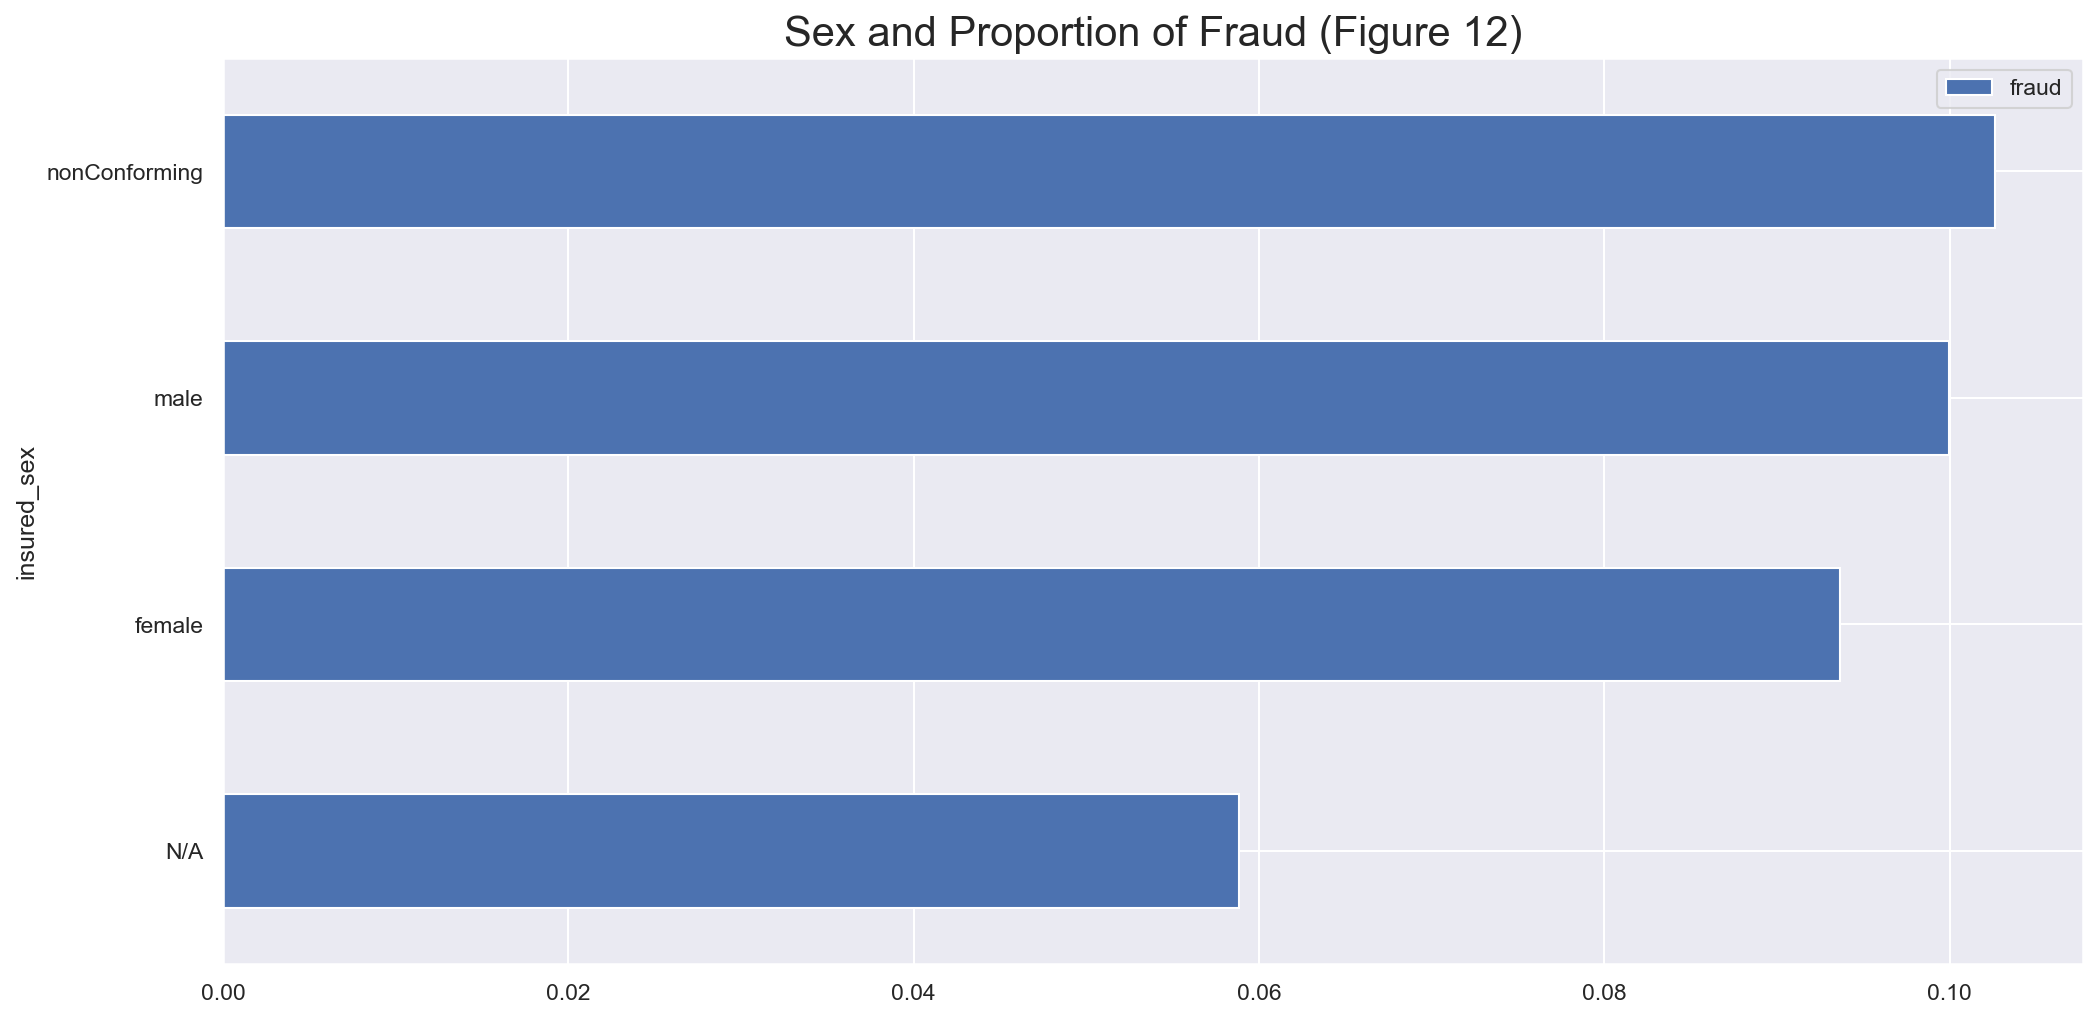

In [37]:
claims[['insured_sex', 'fraud']].fillna('N/A').groupby('insured_sex').agg('mean').plot(kind='barh')
plt.title("Sex and Proportion of Fraud (Figure 12)",fontsize=20)

Text(0, 0.5, 'Insured Occupation')

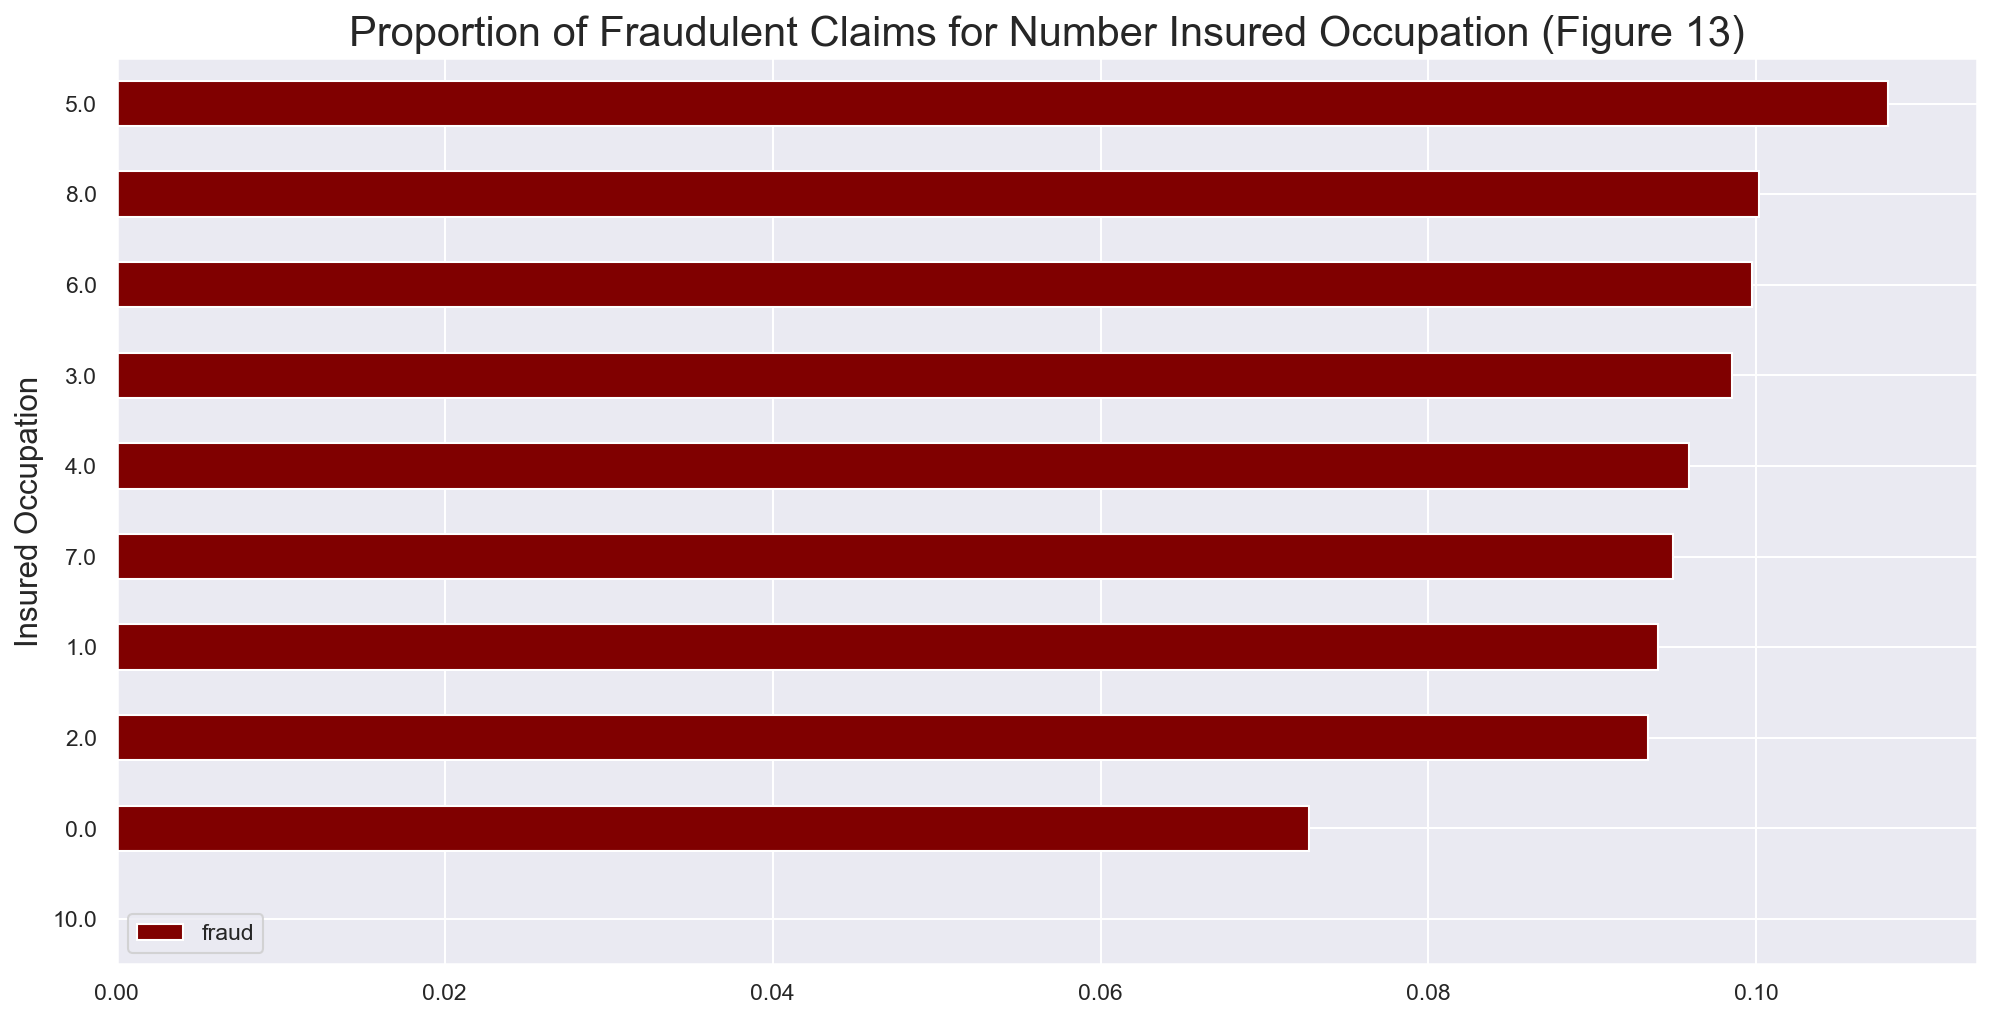

In [38]:
claims[['insured_occupation', 'fraud']].fillna(0).groupby('insured_occupation').agg('mean').sort_values("fraud").plot(kind='barh', color='maroon')
plt.title("Proportion of Fraudulent Claims for Number Insured Occupation (Figure 13)", fontsize=20)
plt.ylabel("Insured Occupation", fontsize=15)

There appears to be a relationship between insured occupation and proportion of fradulent claim. What stood out to me was insured_occupation 10 had 0 fradulent claim. I believe that this will be a helpful feature in our model. 

# Processing and Modeling

## Feature Selection
I will be using the following features in the model: 

1. `name` - It appears that there are far higher proportions of fraudulent claims for certain types of claim. 

    Encoding Approach : Hot-One Encoding 


2. `incident_severity`- For incident severity, it appears that Total Loss has the highest proportion of fraudulent claim. 
    
    Encoding Approach - Ordinal Encoding. 
    
    
3. `auto_make` - Although not all claims are collisions, during my EDA I see that certain make of cars have a noticebly higher proportion of fradulent claims (SUBURU) while others (TESLA 0% fraud) have lower proportions. 


4. `months_as_customer` - Out of everything, I believe this was one of the most strongest feature to use. From the boxplot (Figure 5), we can see that the distribution of months as customer different significantly between fraudulent and non-fraudulent. 

5. `month` - Some months have a lot of frauds, whereas some months have very little. 


6. `hour` - There are spikes in fraud claims in certain hours. So I think this will be a great feature

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [40]:
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

def basicProcessing(data): 
    """Cleans up the data by fixing spelling mistakes and same categories spelt differently"""
    data = data.copy() 
    data = data.drop_duplicates()
    data = data.dropna(how='all')
    data['name'] = data['name'].str.replace('-','').str.lower().str.rstrip()
    data['name'] = data['name'].str.replace("collision at intersection", "collision at intersect")
    data['auto_make'] = data['auto_make'].str.replace("SUBUWU", "SUBARU") # UWU 
    data['lossdatetime'] = convertToDateTimeObject(data['lossdate'])
    data['month'] = data['lossdatetime'].apply(lambda x:x.month)
    data['lossdatetime'] = convertToDateTimeObject(data['lossdate'])
    data['hour'] = data['lossdatetime'].apply(lambda x: x.hour)
    fullClaims['insured_occupation'] = claims[["insured_occupation"]].fillna(0)
    return data 

def targetEncoding(data, target, by):
    """Group by target and aggegrate using mean. Then target encode using the corresponding mean"""
    data = data.copy()
    autoMake = data[[by,target]].groupby(target).agg('mean')
    data[target] = data[target].replace(tuple(autoMake.index), tuple([round(sum(i),3) for i in autoMake.values]))
    return data
    
def damageOrdinalEncoding(data):
    """Perform Ordinal Encoding on the damage Column"""
    data = data.copy()
    damages = ("Total Loss", "Major Damage", "Minor Damage", "Trivial Damage")
    damagesEncode = (4, 3, 2, 1)
    data['incident_severity'] = data['incident_severity'].replace(damages,damagesEncode)
    return data

def ohe_name(data, target):
    """
    One-hot-encodes name.  New columns are of the form 0x_QUALITY.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[[target]]) # determine specific values that a categorical feature can take
    dummies = pd.DataFrame(oh_enc.transform(data[["name"]]).todense(), 
                       columns = oh_enc.get_feature_names(),
                       index = data.index
                )
    return data.join(dummies).drop(columns=[target])

pipeline_model1 = [
    (targetEncoding, None, {'target':'auto_make', 'by':'fraud'}),
    (damageOrdinalEncoding, None, None),
    (ohe_name, None, {'target': 'name'})
    
]

I will now split the data into training and testing sets and then deal with class imbalance through either oversampling or undersampling. The reason why we do not want to do this to our test data.

What is overasmpling or undersampling? 

**Oversampling** : duplicate or create new synthetic examples in the minority class

**UnderSampling** : delete or merge examples in the majority class. 

I decided to go with oversampling! Why? Undersampling deletes what could be useful data. With oversampling, we will not be losing any information. 

### Split to training and testing.

In [41]:
features = ['name', 'fraud','month', 'incident_severity', 
                         'auto_make', "months_as_customer", "hour"]

fullClaims = pd.read_csv("Claims.csv")
fullClaims = basicProcessing(fullClaims)
fullClaims = fullClaims[features]
fullClaims = fullClaims.dropna()
fullClaims = fullClaims[~(fullClaims['name'] == 'hail')]

# Split testing and training 
X = fullClaims.drop(columns=['fraud'])
y = fullClaims['fraud']

# Ensures even splitting of fraudulent activities vs not among both test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

In [42]:
features = ['name', 'fraud','month', 'incident_severity', 
                         'auto_make', "months_as_customer", "hour"]

fullClaims = pd.read_csv("Claims.csv")
fullClaims = basicProcessing(fullClaims)
fullClaims = fullClaims[features]
fullClaims = fullClaims.dropna()
fullClaims = fullClaims[~(fullClaims['name'] == 'hail')]

# Split testing and training 
X = fullClaims.drop(columns=['fraud'])
y = fullClaims['fraud']

# Ensures even splitting of fraudulent activities vs not among both test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

### Oversampling 

In [43]:
oversample = RandomOverSampler(sampling_strategy='minority')
oversample = RandomOverSampler(sampling_strategy=0.6)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

train_data_over = X_train_over.join(y_train_over)

oversample = RandomOverSampler(sampling_strategy='minority')
oversample = RandomOverSampler(sampling_strategy=0.6)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

train_data_over = X_train_over.join(y_train_over)

In [44]:
X_train_final, y_train_final = process_data_gm(train_data_over, pipeline_model1, 'fraud')
X_test_final, y_test_final = process_data_gm(test_data, pipeline_model1, 'fraud')

# Random Forest Classifier 

In [45]:
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

In [76]:
model = BalancedRandomForestClassifier(n_estimators = 100, random_state = 0)
model.fit(X_train_final, y_train_final)

BalancedRandomForestClassifier(random_state=0)

In [77]:
y_pred_rf = model.predict(X_test_final)
y_pred_rf

array([1., 0., 0., ..., 0., 1., 0.])

# Model Evaluation 

In general, our training accuracy is around 99.4% whereas our testing accuracy is 95.94%.

Although this number is high, it is important to check other evaluations, such as the precision, recall, and f1 scores. Why? let's say only 4.06% of our data was fraud and the other 95.94% was nonfraudulent. If our classifier only classifies non-fraudulent correctly, then we have a 95.94% accuracy but we didn't actually catch any fraud. It's useless! 


1. **Precision - What percent of your predictions were correct?** 

    TP/(TP+FP)

2. **Recall - What percent of the positive cases did you catch?** 

    TP/(TP+FN)

3. **F1 - What percent of positive predictions were correct?**

    2 * (Recall * Precision)/ (Recall + Precision)

4. **AUC - Measure the ability of a classifier to distinguish between classes** 

    The closer the AUC is to 1, the better the classifier is at distinguishing between class. 

    0.5 means it has no classification abilities. 
    

**Business interpretation: Should we prioritize precision or recall?**

If we work to drive precision to 100%, then while all the fradulent claims we marked as fraud are indeed fraud, many other fradulent are slipping through which makes the company lose money. However, if we focus on driving recall to 100%, we might misclasify customers with non-fradulent claims as fradulent; we may piss them off! I would suggest to try and drive the 100% recall up so that when a claim is marked as fradulent, the system can flag it and a person within the company can look at the claim to validate. However, the downside to this is if we're flagging hundreds of thousandas of claims as fradulent (still catching all fradulent), it might not be feasible to look into all of them. 

In [78]:
print("Training Accuracy: ", model.score(X_train_final, y_train_final))
print('Testing Accuracy: ', model.score(X_test_final, y_test_final))
cr = classification_report(y_test_final,  y_pred_rf)
print(cr)

Training Accuracy:  0.9986163112485756
Testing Accuracy:  0.9627192982456141
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      3289
         1.0       0.78      0.87      0.82       359

    accuracy                           0.96      3648
   macro avg       0.88      0.92      0.90      3648
weighted avg       0.97      0.96      0.96      3648



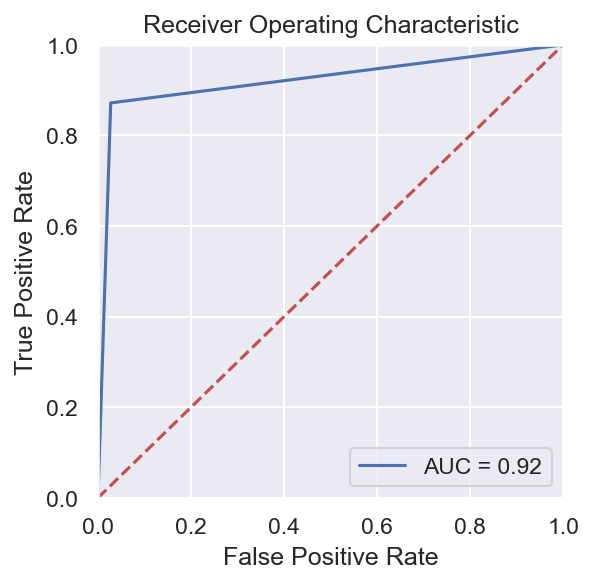

In [79]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test_final, y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)
f, ax = plt.subplots(figsize=(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 0, 'Relative Importance')

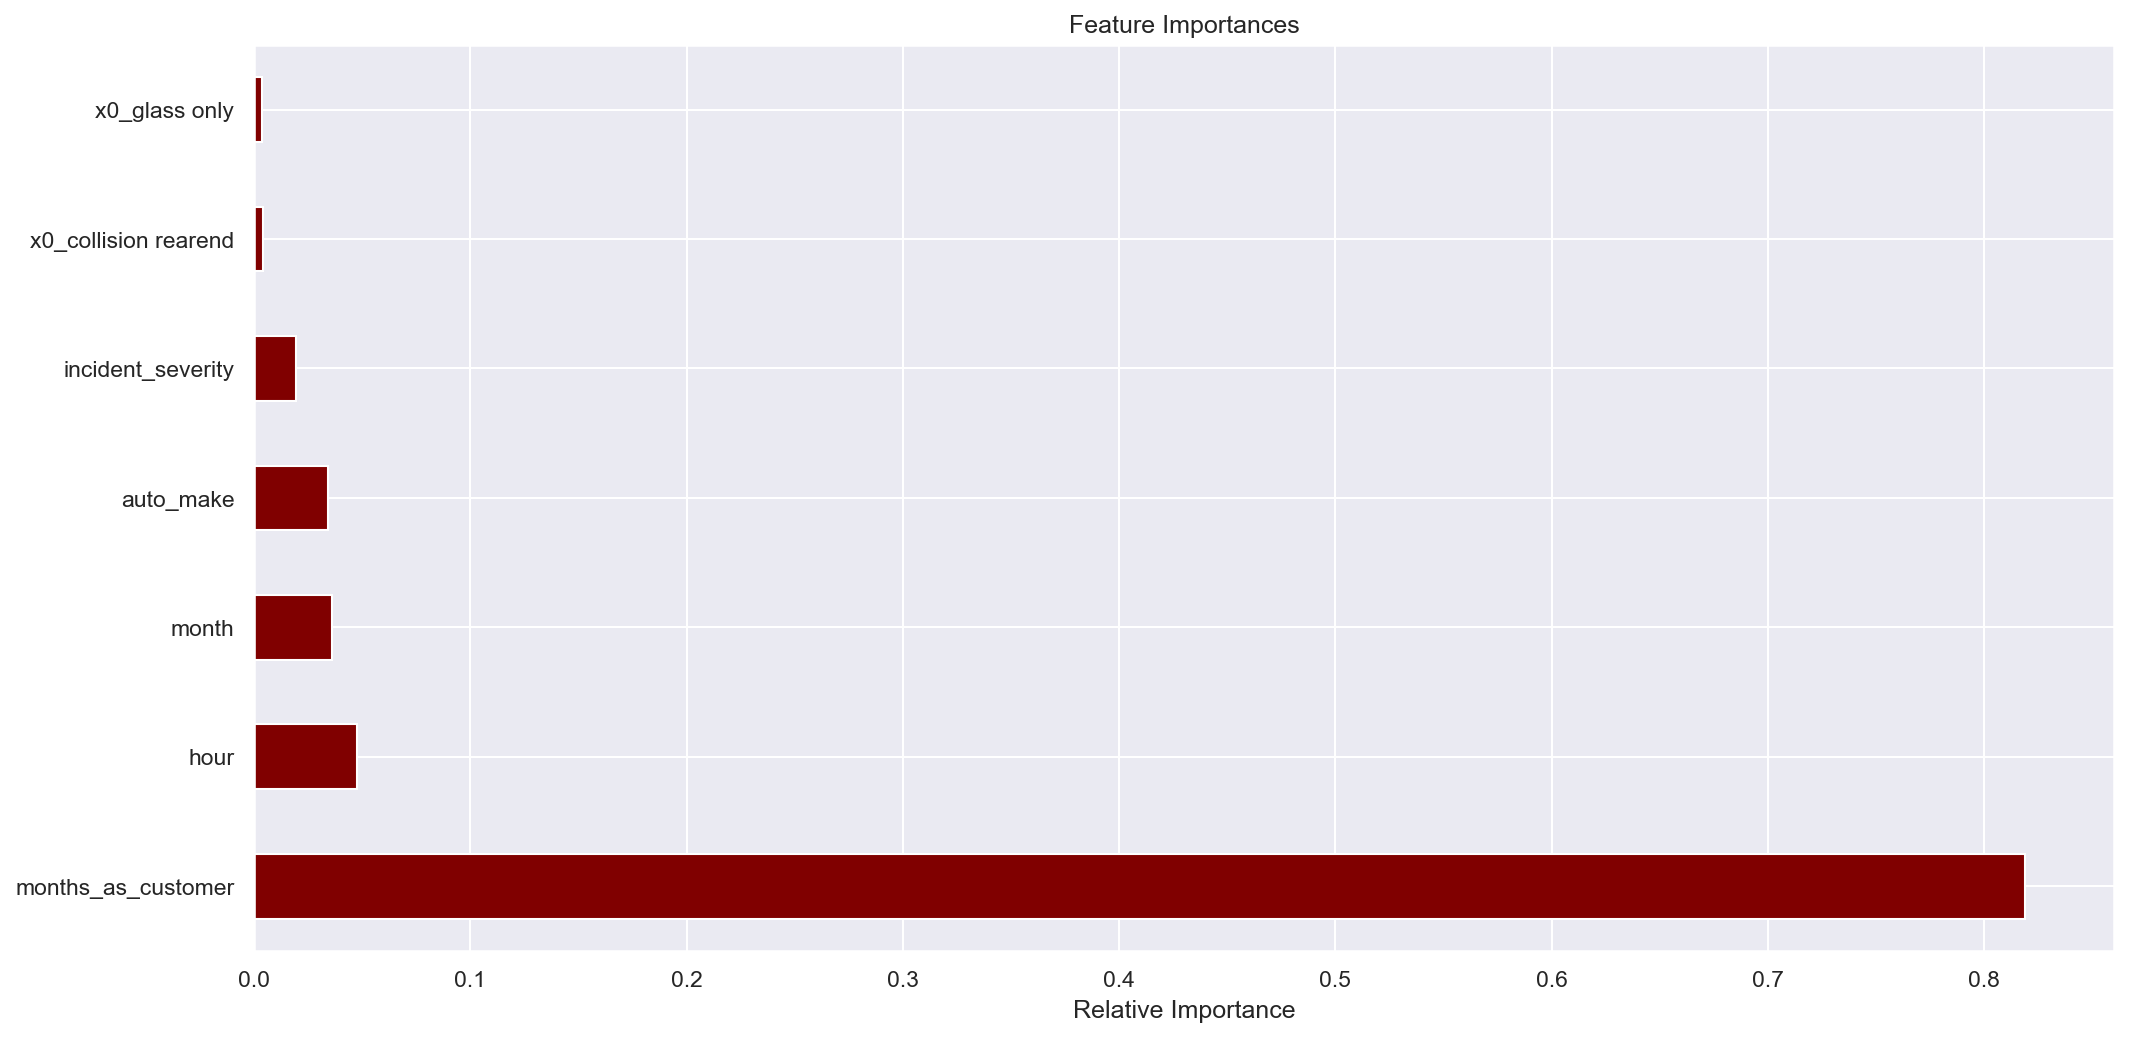

In [80]:
features = np.array(ohe_name(fullClaims,'name').drop(columns=['fraud']).columns)
plt.title('Feature Importances')
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(7).plot(kind='barh', color = 'maroon')
plt.xlabel('Relative Importance')

# Easy Ensemble Classifier 



In [63]:
from imblearn.ensemble import EasyEnsembleClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [68]:
model1 = EasyEnsembleClassifier(n_estimators = 100, random_state = 0)
model1.fit(X_train_final, y_train_final)

EasyEnsembleClassifier(n_estimators=100, random_state=0)

In [69]:
y_pred_ef1 = model1.predict(X_test_final)

**Underfitted Model**

In [70]:
print("Training Accuracy: ", model1.score(X_train_final, y_train_final))
print('Testing Accuarcy: ', model1.score(X_test_final, y_test_final))

Training Accuracy:  0.9485593358293993
Testing Accuarcy:  0.9835526315789473


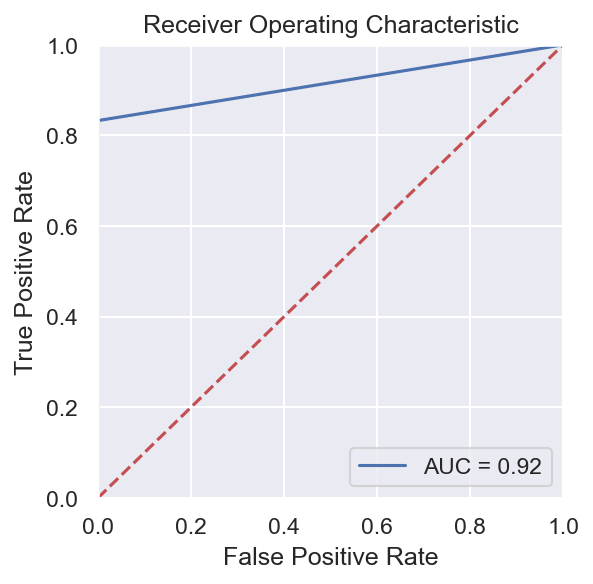

In [71]:
fpr, tpr, threshold = metrics.roc_curve(y_test_final, y_pred_ef1)
roc_auc = metrics.auc(fpr, tpr)
f, ax = plt.subplots(figsize=(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()